# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [1]:
# Nothing To Do

### Imports


In [2]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [3]:
files_2 = os.listdir(os.curdir + "/second_try")
files_3 = os.listdir(os.curdir + "/third_try")
parquet_files = []
for file in files_2:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
for file in files_3:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
print(parquet_files[1])

results_car_dataset_bioautoml_lgbm_classifier_pipeline_6.parquet


In [4]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    if parts[1] == "dataset":
        dataset = parts[0]
        method = parts[2]
        fold = parts[-1]
    elif parts[2] == "dataset":
        dataset = parts[0] + parts[1]
        method = parts[3]
        fold = parts[-1]
    elif parts[3] == "dataset":
        dataset = parts[0] + parts[1] + parts[2]
        method = parts[4]
        fold = parts[-1]
    if method == "xxx":
        print("xxx is not a valid method name")
    else:
        try:
            df = pd.read_parquet("second_try/" + file)
        except:
            df = pd.read_parquet("third_try/" + file)
        df = df[df['status'] == 'success']
        try:
            metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
            value = np.average(metric_accuracy)
            df_all = df_all.append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
        except KeyError as e:
            print(str(e) + " for file " + str(file))
print(df_all)

'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_mljar_lgbm_classifier_pipeline_4.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_blood_transfusion_service_center_dataset_original_lgbm_classifier_pipeline_4.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_mljar_lgbm_classifier_pipeline_5.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_mljar_lgbm_classifier_pipeline_0.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_mljar_lgbm_classifier_pipeline_2.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_lgbm_classifier_pipeline_6.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_original_lgbm_classifier_pipeline_4.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_abalone_dataset_mljar_lgbm_classifier_pipeline_3.parquet
'metric:roc_auc_ovo [

In [5]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

              Dataset              Method     Value
0             abalone            autofeat  0.819402
1             abalone           autogluon  0.988046
2             abalone  correlationBasedFS  0.871825
3             abalone               mljar  0.906537
4             abalone            original  0.922055
..                ...                 ...       ...
98   winequalitywhite           autogluon  0.862041
99   winequalitywhite           bioautoml  0.814809
100  winequalitywhite  correlationBasedFS  0.898586
101  winequalitywhite                 h2o  0.931301
102  winequalitywhite            original  0.793592

[103 rows x 3 columns]


In [6]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

              Dataset              Method     Value    StdDev  \
0             abalone            autofeat  0.819402  0.101732   
1             abalone           autogluon  0.988046  0.000697   
2             abalone  correlationBasedFS  0.871825  0.064189   
3             abalone               mljar  0.906537  0.027967   
4             abalone            original  0.922055  0.029714   
..                ...                 ...       ...       ...   
98   winequalitywhite           autogluon  0.862041  0.086511   
99   winequalitywhite           bioautoml  0.814809  0.119195   
100  winequalitywhite  correlationBasedFS  0.898586  0.136011   
101  winequalitywhite                 h2o  0.931301  0.004015   
102  winequalitywhite            original  0.793592  0.098753   

                              Value_with_StdDev  
0       0.8194015784898294 ± 0.1017316426295408  
1    0.9880464056575461 ± 0.0006970561316272044  
2      0.8718249558849116 ± 0.06418907916916664  
3     0.90653666904

In [7]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+----+------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+-------------------------------------------+
|    |        Dataset         |                 autofeat                  |                 autogluon                  |                 bioautoml                 |                   boruta                   |            correlationBasedFS             |                    h2o                    |                   mljar                   |                 original                  |
+----+------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------

### Boxplots

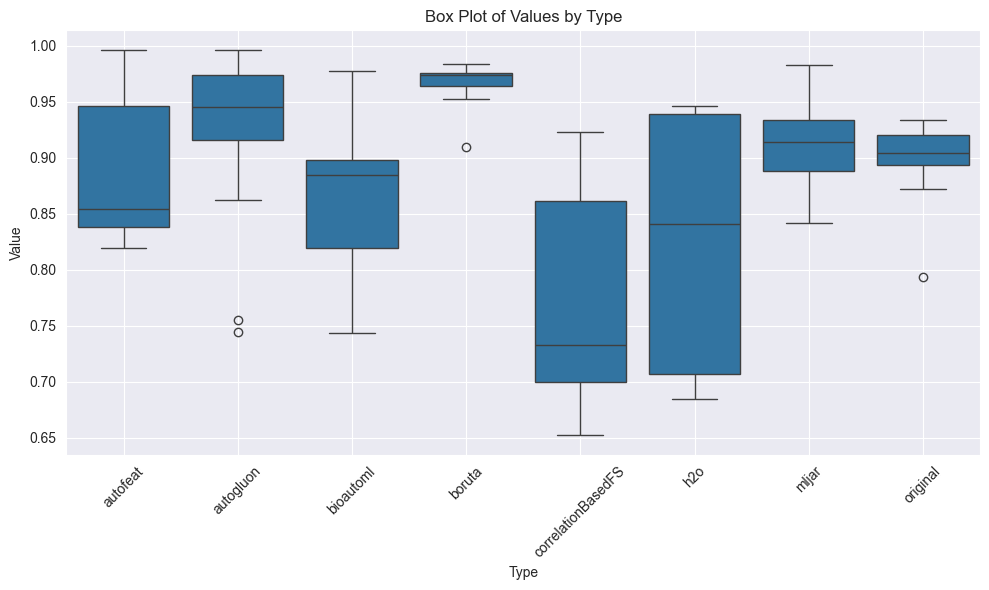

In [8]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()